# Cross-cell type performance of spatial aging clocks

This notebook contains plots applying spatial aging clocks across different cell types to understand the generalization of performance across cell types (e.g. are the spatial aging clocks highly cell type-specific?)

**Associated manuscript figures/tables:**
- Extended Data Figures: 5d


**Inputs required:**
- `results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad` - AnnData object for coronal sections data with spatial aging clock predictions (generated from `cv_train_clock.py`)
- `results/clocks/lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_*.pkl` - pickle files containing sklearn Pipeline objects of spatial aging clocks (generated from `full_train_clock.py`)
- `results/clocks/lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20_*.h5ad` - AnnData object for coronal sections data for different cell types (generated from `full_train_clock.py`)


**Conda environment used**: `requirements/merfish.txt`


In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
import seaborn as sns
from sklearn.neighbors import BallTree

from clock_preprocessing import *

In [8]:
restricted_celltype_subset = ['Neuron-Excitatory','Neuron-MSN','Astrocyte','Microglia','Oligodendrocyte','OPC','Endothelial','Pericyte','VSMC','Ependymal','Neuroblast','NSC','Macrophage', 'T cell']

### SpatialSmooth clock cross-celltype predictions

In [10]:
# read in spatialPB data (just to reference metadata)
adata = sc.read_h5ad("results/clocks/anndata/lasso_loocv_predicted_age_correlation_n30_spatialsmoothonsmooth_alpha08_nneigh20.h5ad")

# order cell types
categories_order = ['Neuron-Excitatory', 'Neuron-Inhibitory', 'Neuron-MSN',
                    'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC',
                    'Endothelial', 'Pericyte', 'VSMC', 'VLMC',
                    'Ependymal', 'Neuroblast', 'NSC', 
                    'Macrophage', 'Neutrophil','T cell', 'B cell']
adata.obs['celltype'] = adata.obs['celltype'].cat.reorder_categories(categories_order)

In [ ]:
# cross-apply clocks

name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"

################################################
celltype_clock_col = []
celltype_applied_col = []
r_col = []
mae_col = []

celltypes = pd.unique(adata.obs.celltype).sort_values()


for ct_clock in celltypes:
    
    if f'{name}_{ct_clock}.pkl' in os.listdir('results/clocks'): # if there exist clock for cell type
        
        # load and apply aging clock
        with open(f'results/clocks/{name}_{ct_clock}.pkl', 'rb') as handle:
            pipeline = pickle.load(handle)
        
        for ct_applied in celltypes:

            # set up data
            sub_adata = sc.read_h5ad(f"results/clocks/{name}_{ct_applied}.h5ad")
            
            # get data
            X = np.array(sub_adata.X).astype('float64')
            
            # make prediction
            preds = pipeline.predict(X)
            
            # get stats
            r,p = pearsonr(preds, sub_adata.obs.age)
            mae = np.mean(np.abs(preds-np.array(sub_adata.obs.age)))

            # add results
            celltype_clock_col.append(ct_clock)
            celltype_applied_col.append(ct_applied)
            r_col.append(r)
            mae_col.append(mae)
            
df = pd.DataFrame(np.vstack((celltype_clock_col,celltype_applied_col,r_col,mae_col)).T,
                  columns=["celltype_clock", "celltype_applied", "pearson", "mae"])

In [5]:
# create dataframe
df["pearson"] = df["pearson"].astype("float64")
df["mae"] = df["mae"].astype("float64")

In [6]:
# save results
df.to_csv(f"results/clocks/applied/crossapplied_{name}.csv")

## Make Dot Plot of Cross-Application Performances

In [5]:
name = "lasso_cv5_nalphas20_spatialsmooth_alpha08_neigh20"
df = pd.read_csv(f"results/clocks/applied/crossapplied_{name}.csv")

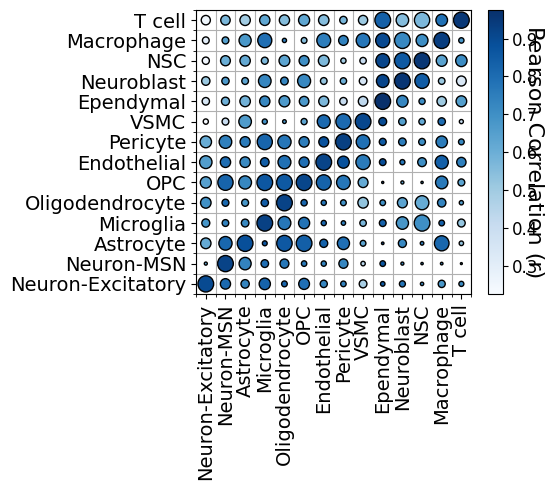

In [6]:
# Make dot plot

celltypesCLOCK = restricted_celltype_subset
celltypesAPPLY = restricted_celltype_subset

df = df[(df['celltype_clock'].isin(celltypesCLOCK))&(df['celltype_applied'].isin(celltypesAPPLY))]


##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(celltypesCLOCK)
M = len(celltypesAPPLY)
ylabels = celltypesCLOCK
xlabels = celltypesAPPLY

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = np.nan_to_num( 1/df.mae.values, 0)
s[s>np.quantile(s,0.9)] = np.quantile(s,0.9) # clip size to 90th percentile
c = np.nan_to_num( df.pearson.values, 0)

fig, ax = plt.subplots(figsize=(5.6,5))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
col = PatchCollection(circles, array=c.flatten(), cmap="Blues",edgecolor='black',linewidth=1)
ax.add_collection(col)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=90, fontsize=14)
ax.set_yticklabels(ylabels, fontsize=14)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

cbar = fig.colorbar(col)
cbar.ax.set_ylabel('Pearson Correlation (r)', rotation=270, fontsize=16)
cbar.ax.tick_params(labelsize=12)


plt.tight_layout()
plt.savefig(f"plots/clocks/crossapplied_{name}_subset.pdf", bbox_inches='tight')
plt.show()

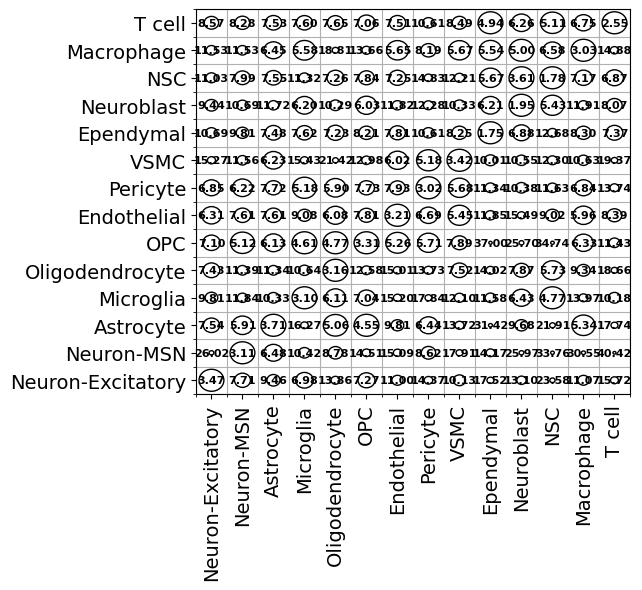

In [7]:
# PRINT LABELS FOR SIZE LEGEND

celltypesCLOCK = restricted_celltype_subset
celltypesAPPLY = restricted_celltype_subset

df = df[(df['celltype_clock'].isin(celltypesCLOCK))&(df['celltype_applied'].isin(celltypesAPPLY))]


##### code from: https://stackoverflow.com/questions/59381273/heatmap-with-circles-indicating-size-of-population
N = len(celltypesCLOCK)
M = len(celltypesAPPLY)
ylabels = celltypesCLOCK
xlabels = celltypesAPPLY

x, y = np.meshgrid(np.arange(M), np.arange(N))
s = np.nan_to_num( 1/df.mae.values, 0)
s[s>np.quantile(s,0.9)] = np.quantile(s,0.9) # clip size to 90th percentile
c = np.nan_to_num( df.pearson.values, 0)

fig, ax = plt.subplots(figsize=(5.6,5))

R = s/s.max()/2.5 # fixes max radius of circles with this scaling
for r, j, i, value in zip(R.flat, x.flat, y.flat, df.mae.values):
    circle = plt.Circle((j, i), radius=r, edgecolor='black', linewidth=1, facecolor="None")
    ax.add_patch(circle)
    ax.annotate(f"{value:.2f}", (j, i), color='black', weight='bold', ha='center', va='center', fontsize=8)

ax.set_xticks(np.arange(M))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(xlabels, rotation=90, fontsize=14)
ax.set_yticklabels(ylabels, fontsize=14)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor')

plt.show()